In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt

class LUNA16ProcessorWithResampling:
    """LUNA16结节处理器 - 包含0.75mm重采样功能"""
    
    def __init__(self, luna16_root: str, output_dir: str, target_spacing: float = 0.75):
        """
        Args:
            luna16_root: LUNA16数据集根目录
            output_dir: NPZ格式输出目录 
            target_spacing: 目标重采样间距(mm)，默认0.75mm
        """
        self.luna16_root = Path(luna16_root)
        self.data_dir = self.luna16_root / "data"
        self.output_dir = Path(output_dir)
        self.target_spacing = target_spacing
        
        # 创建输出目录
        self.cancer_dir = self.output_dir / "cancer"
        self.nocancer_dir = self.output_dir / "nocancer"
        self.cancer_dir.mkdir(parents=True, exist_ok=True)
        self.nocancer_dir.mkdir(parents=True, exist_ok=True)
        
        # 加载注释数据
        self.candidates_file = self.luna16_root / "candidates.csv"
        self.candidates = self._load_candidates()
        
        print(f"🔧 LUNA16处理器初始化完成")
        print(f"   数据目录: {self.data_dir}")
        print(f"   输出目录: {self.output_dir}")
        print(f"   目标spacing: {self.target_spacing}mm")
        print(f"   候选结节总数: {len(self.candidates)}")
        
        if 'class' in self.candidates.columns:
            cancer_count = len(self.candidates[self.candidates['class'] == 1])
            nocancer_count = len(self.candidates[self.candidates['class'] == 0])
            print(f"   - 恶性结节: {cancer_count}")
            print(f"   - 正常结节: {nocancer_count}")
    
    def _load_candidates(self) -> pd.DataFrame:
        """加载候选结节数据"""
        if self.candidates_file.exists():
            return pd.read_csv(self.candidates_file)
        else:
            print(f"❌ 未找到candidates.csv: {self.candidates_file}")
            return pd.DataFrame()
    
    def find_mhd_files(self) -> List[Path]:
        """查找所有MHD文件"""
        mhd_files = list(self.data_dir.glob("*.mhd"))
        print(f"📁 找到 {len(mhd_files)} 个MHD文件")
        return sorted(mhd_files)
    
    def load_and_resample_mhd(self, mhd_path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        加载MHD图像并重采样到指定spacing
        
        Returns:
            image: 重采样后的图像 (Z, Y, X)
            new_spacing: 新的spacing (Z, Y, X)
            origin: 图像原点 (X, Y, Z)
        """
        # 读取原始图像
        itk_image = sitk.ReadImage(str(mhd_path))
        
        # 获取原始信息
        original_spacing = itk_image.GetSpacing()  # (X, Y, Z)
        origin = itk_image.GetOrigin()             # (X, Y, Z)
        original_size = itk_image.GetSize()        # (X, Y, Z)
        
        # 目标spacing
        target_spacing_xyz = [self.target_spacing, self.target_spacing, self.target_spacing]
        
        # 计算新尺寸
        new_size = [
            int(np.round(original_size[0] * original_spacing[0] / target_spacing_xyz[0])),
            int(np.round(original_size[1] * original_spacing[1] / target_spacing_xyz[1])), 
            int(np.round(original_size[2] * original_spacing[2] / target_spacing_xyz[2]))
        ]
        
        # 重采样
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing(target_spacing_xyz)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(itk_image.GetDirection())
        resampler.SetOutputOrigin(origin)
        resampler.SetTransform(sitk.Transform())
        resampler.SetDefaultPixelValue(-1000)  # 空气HU值
        resampler.SetInterpolator(sitk.sitkLinear)
        
        # 执行重采样
        resampled_itk = resampler.Execute(itk_image)
        
        # 转换为numpy数组
        image = sitk.GetArrayFromImage(resampled_itk)  # (Z, Y, X)
        new_spacing = np.array(target_spacing_xyz)[::-1]  # (Z, Y, X)
        
        return image, new_spacing, np.array(origin)
    
    def world_to_voxel(self, world_coords: np.ndarray, origin: np.ndarray, 
                      spacing: np.ndarray) -> np.ndarray:
        """世界坐标转体素坐标"""
        x, y, z = world_coords
        
        # 计算体素坐标
        voxel_x = (x - origin[0]) / spacing[2]  # X方向
        voxel_y = (y - origin[1]) / spacing[1]  # Y方向
        voxel_z = (z - origin[2]) / spacing[0]  # Z方向
        
        return np.array([voxel_z, voxel_y, voxel_x])
    
    def extract_patch_3d(self, image: np.ndarray, center: np.ndarray, 
                        patch_size: Tuple[int, int, int] = (3, 64, 64)) -> Optional[np.ndarray]:
        """提取3D patch"""
        z_c, y_c, x_c = center
        d, h, w = patch_size
        
        # 计算边界
        z_start = int(z_c - d // 2)
        z_end = z_start + d
        y_start = int(y_c - h // 2)
        y_end = y_start + h
        x_start = int(x_c - w // 2)
        x_end = x_start + w
        
        # 边界检查和调整
        if (z_start < 0 or z_end > image.shape[0] or
            y_start < 0 or y_end > image.shape[1] or
            x_start < 0 or x_end > image.shape[2]):
            
            # 尝试调整到边界内
            z_start = max(0, min(z_start, image.shape[0] - d))
            z_end = z_start + d
            y_start = max(0, min(y_start, image.shape[1] - h))
            y_end = y_start + h
            x_start = max(0, min(x_start, image.shape[2] - w))
            x_end = x_start + w
            
            # 如果仍然超出边界，返回None
            if (z_end > image.shape[0] or y_end > image.shape[1] or x_end > image.shape[2]):
                return None
        
        return image[z_start:z_end, y_start:y_end, x_start:x_end]
    
    def normalize_hu_values(self, patch: np.ndarray) -> np.ndarray:
        """标准化HU值到0-255"""
        # 限制HU值范围 
        patch_clipped = np.clip(patch, -1000, 400)
        
        # 标准化到[0, 255]
        normalized = ((patch_clipped + 1000) / 1400.0 * 255).astype(np.uint8)
        
        return normalized
    
    def process_single_mhd(self, mhd_path: Path, max_nodules: Optional[int] = None) -> Dict[str, int]:
        """处理单个MHD文件"""
        series_uid = mhd_path.stem
        print(f"\n🔄 处理: {series_uid}")
        
        # 查找该系列的候选结节
        series_candidates = self.candidates[self.candidates['seriesuid'] == series_uid]
        
        if len(series_candidates) == 0:
            print(f"   ⚠️  无候选结节")
            return {'cancer': 0, 'nocancer': 0}
        
        if max_nodules:
            series_candidates = series_candidates.head(max_nodules)
        
        print(f"   📊 候选结节: {len(series_candidates)}")
        
        try:
            # 加载并重采样图像
            image, spacing, origin = self.load_and_resample_mhd(mhd_path)
            print(f"   📐 重采样后: shape={image.shape}, spacing={spacing}")
            
            stats = {'cancer': 0, 'nocancer': 0}
            
            for idx, candidate in series_candidates.iterrows():
                try:
                    # 世界坐标
                    world_coords = np.array([
                        candidate['coordX'],
                        candidate['coordY'], 
                        candidate['coordZ']
                    ])
                    
                    # 转换为体素坐标
                    voxel_coords = self.world_to_voxel(world_coords, origin, spacing)
                    
                    # 提取patch
                    patch = self.extract_patch_3d(image, voxel_coords)
                    
                    if patch is not None and patch.shape == (3, 64, 64):
                        # 标准化
                        patch_norm = self.normalize_hu_values(patch)
                        
                        # 确定类别和保存路径
                        node_class = int(candidate.get('class', 0))
                        if node_class == 1:
                            save_dir = self.cancer_dir
                            class_name = "cancer"
                            stats['cancer'] += 1
                        else:
                            save_dir = self.nocancer_dir
                            class_name = "nocancer"
                            stats['nocancer'] += 1
                        
                        # 生成文件名
                        filename = f"{series_uid}_idx{idx}_{class_name}.npz"
                        save_path = save_dir / filename
                        
                        # 创建简单掩码
                        mask = np.zeros_like(patch_norm, dtype=np.uint8)
                        mask[1, 32, 32] = 1  # 中心点
                        
                        # 保存
                        np.savez_compressed(
                            save_path,
                            data=patch_norm,
                            mask=mask,
                            class_label=node_class,
                            world_coords=world_coords,
                            voxel_coords=voxel_coords,
                            spacing=spacing,
                            series_uid=series_uid
                        )
                        
                        print(f"     ✅ {class_name}: {filename}")
                        
                    else:
                        print(f"     ❌ patch提取失败 idx={idx}")
                        
                except Exception as e:
                    print(f"     ❌ 处理候选结节{idx}失败: {e}")
                    continue
            
            print(f"   📊 完成: cancer={stats['cancer']}, nocancer={stats['nocancer']}")
            return stats
            
        except Exception as e:
            print(f"   ❌ 处理MHD失败: {e}")
            return {'cancer': 0, 'nocancer': 0}
    
    def process_test_data(self, max_files: int = 3, max_nodules_per_file: int = 10):
        """测试处理少量数据"""
        mhd_files = self.find_mhd_files()[:max_files]
        
        print(f"\n🧪 测试模式: 处理前{max_files}个文件")
        print("="*50)
        
        total_stats = {'cancer': 0, 'nocancer': 0, 'processed_files': 0}
        
        for i, mhd_path in enumerate(mhd_files):
            print(f"[{i+1}/{len(mhd_files)}]", end=" ")
            stats = self.process_single_mhd(mhd_path, max_nodules_per_file)
            
            total_stats['cancer'] += stats['cancer']
            total_stats['nocancer'] += stats['nocancer']
            total_stats['processed_files'] += 1
        
        print(f"\n✅ 测试完成!")
        print(f"📊 总计: cancer={total_stats['cancer']}, nocancer={total_stats['nocancer']}")
        
        return total_stats


print("🚀 改进版LUNA16处理器已定义 (包含0.75mm重采样)")

🚀 改进版LUNA16处理器已定义 (包含0.75mm重采样)


In [2]:
# 🔄 精简版处理器 - 减少输出，避免卡死
import random
import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt

class LUNA16QuietProcessor:
    """静默版LUNA16处理器 - 最少输出，只处理高质量样本(Z>500)"""
    
    def __init__(self, 
                 luna16_root: str = "/home/maweicheng/database/LUNA",
                 output_dir: str = "/home/maweicheng/database/LUNA/nocancer_patches",
                 target_count: int = 5000,
                 min_slices: int = 500):
        
        self.luna16_root = Path(luna16_root)
        self.data_dir = self.luna16_root / "data"
        self.output_dir = Path(output_dir)
        self.target_count = target_count
        self.min_slices = min_slices  # 最小切片数要求
        
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        # 加载数据
        self.candidates_file = self.luna16_root / "candidates.csv"
        self.candidates = pd.read_csv(self.candidates_file) if self.candidates_file.exists() else pd.DataFrame()
        
        print(f"🚀 高质量静默处理器初始化完成")
        print(f"   目标: {target_count}个patches")
        print(f"   最小切片数要求: >{min_slices}")
        print(f"   候选结节: {len(self.candidates)}个")
    
    def check_series_quality(self, series_uid: str) -> bool:
        """检查系列质量 - 切片数是否>500"""
        mhd_path = self.data_dir / f"{series_uid}.mhd"
        if not mhd_path.exists():
            return False
        
        try:
            itk_image = sitk.ReadImage(str(mhd_path))
            Z = itk_image.GetSize()[2]  # 切片数
            return Z > self.min_slices
        except:
            return False
    
    def lung_window_normalize(self, image, low=-1000, high=400):
        """肺窗归一化"""
        img = np.clip(image, low, high)
        img = (img - low) / (high - low)
        return img.astype(np.float32)
    
    def extract_patch_from_channels(self, volume, center, size=64):
        """提取patch"""
        C, H, W = volume.shape
        cy, cx = int(center[0]), int(center[1])
        half = size // 2
        y1, y2 = cy - half, cy + half
        x1, x2 = cx - half, cx + half

        pad_top = max(0, -y1)
        pad_left = max(0, -x1)
        pad_bottom = max(0, y2 - H)
        pad_right = max(0, x2 - W)

        y1c, y2c = max(0, y1), min(H, y2)
        x1c, x2c = max(0, x1), min(W, x2)

        patch = volume[:, y1c:y2c, x1c:x2c]
        pad_width = ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right))
        patch_padded = np.pad(patch, pad_width=pad_width, mode='constant', constant_values=0)
        
        if patch_padded.shape[1] != size or patch_padded.shape[2] != size:
            patch_padded = np.resize(patch_padded, (C, size, size))
        return patch_padded
    
    def world_to_voxel(self, world_coords, origin, spacing):
        """坐标转换"""
        x, y, z = world_coords
        voxel_x = (x - origin[0]) / spacing[2]
        voxel_y = (y - origin[1]) / spacing[1] 
        voxel_z = (z - origin[2]) / spacing[0]
        return np.array([voxel_z, voxel_y, voxel_x])
    
    def process_single_series(self, series_uid: str, max_patches: int = 50):
        """处理单个系列 - 静默版，只处理高质量样本"""
        mhd_path = self.data_dir / f"{series_uid}.mhd"
        if not mhd_path.exists():
            return []
        
        try:
            # 加载图像
            itk_image = sitk.ReadImage(str(mhd_path))
            volume = sitk.GetArrayFromImage(itk_image)
            spacing = np.array(itk_image.GetSpacing())[::-1]
            origin = np.array(itk_image.GetOrigin())
            
            Z, H, W = volume.shape
            
            # 检查切片数要求
            if Z <= self.min_slices:
                return []
            
            volume_norm = self.lung_window_normalize(volume)
            
            # 获取结节
            series_candidates = self.candidates[self.candidates['seriesuid'] == series_uid]
            if len(series_candidates) == 0:
                return []
            
            # 随机选择结节
            selected = series_candidates.sample(n=min(max_patches, len(series_candidates)), random_state=42)
            
            patches = []
            for _, candidate in selected.iterrows():
                try:
                    world_coords = np.array([candidate['coordX'], candidate['coordY'], candidate['coordZ']])
                    voxel_coords = self.world_to_voxel(world_coords, origin, spacing)
                    
                    z_c, y_c, x_c = voxel_coords
                    if not (0 <= z_c < Z and 0 <= y_c < H and 0 <= x_c < W):
                        continue
                    
                    # 3个切片
                    target_slice = int(z_c)
                    slice_indices = [
                        max(0, target_slice - 1),
                        target_slice,
                        min(Z - 1, target_slice + 1)
                    ]
                    
                    stacked = np.stack([volume_norm[idx] for idx in slice_indices], axis=0)
                    patch = self.extract_patch_from_channels(stacked, (y_c, x_c), size=64)
                    
                    if patch.shape == (3, 64, 64):
                        patches.append(patch)
                
                except:
                    continue
            
            return patches
            
        except:
            return []
    
    def augment_patch(self, patch):
        """简单增强"""
        aug_patch = patch.copy()
        
        # 随机操作
        if random.random() < 0.5:
            k = random.randint(1, 3)
            aug_patch = np.rot90(aug_patch, k=k, axes=(1, 2))
        
        if random.random() < 0.5:
            if random.random() < 0.5:
                aug_patch = np.flip(aug_patch, axis=1)
            else:
                aug_patch = np.flip(aug_patch, axis=2)
        
        return aug_patch
    
    def generate_patches_quiet(self):
        """静默生成patches - 只从高质量样本提取"""
        print("🔄 开始静默处理高质量样本...")
        
        # 获取系列列表
        mhd_files = list(self.data_dir.glob("*.mhd"))
        
        # 分析高质量系列和结节分布
        high_quality_series = []
        print(f"📊 检查{len(mhd_files)}个样本的质量...")
        
        for i, mhd_file in enumerate(mhd_files):
            if i % 100 == 0:
                print(f"   质量检查进度: {i}/{len(mhd_files)}")
                
            series_uid = mhd_file.stem
            
            # 检查切片数
            if self.check_series_quality(series_uid):
                # 检查结节数
                nodule_count = len(self.candidates[self.candidates['seriesuid'] == series_uid])
                if nodule_count > 0:
                    high_quality_series.append((series_uid, nodule_count))
        
        print(f"✅ 找到{len(high_quality_series)}个高质量样本(Z>{self.min_slices})")
        
        if len(high_quality_series) == 0:
            print("❌ 没有找到符合要求的高质量样本")
            return 0
        
        # 按结节数排序
        high_quality_series.sort(key=lambda x: x[1], reverse=True)
        
        # 生成patches
        all_patches = []
        patches_per_series = max(10, self.target_count // len(high_quality_series))
        
        print(f"🎯 从{len(high_quality_series)}个高质量样本生成patches...")
        
        for i, (series_uid, nodule_count) in enumerate(high_quality_series):
            if i % 20 == 0:  # 每20个打印进度
                print(f"   进度: {i}/{len(high_quality_series)}, 已生成: {len(all_patches)}")
            
            patches = self.process_single_series(series_uid, patches_per_series)
            all_patches.extend(patches)
            
            if len(all_patches) >= self.target_count:
                break
        
        # 数据增强补足
        if len(all_patches) < self.target_count:
            needed = self.target_count - len(all_patches)
            print(f"🔄 数据增强补足{needed}个patches...")
            for i in range(needed):
                if len(all_patches) > 0:
                    base_patch = random.choice(all_patches)
                    aug_patch = self.augment_patch(base_patch)
                    all_patches.append(aug_patch)
        
        # 截断到目标数量
        if len(all_patches) > self.target_count:
            all_patches = all_patches[:self.target_count]
        
        print(f"✅ 生成完成: {len(all_patches)}个高质量patches")
        
        # 保存
        print("💾 保存中...")
        success_count = 0
        
        for i, patch in enumerate(all_patches):
            if i % 1000 == 0:
                print(f"   保存: {i}/{len(all_patches)}")
            
            try:
                filename = f"patch_slice{i:03d}_det0.npz"
                save_path = self.output_dir / filename
                np.savez_compressed(save_path, data=patch)
                success_count += 1
            except:
                continue
        
        print(f"🎉 完成! 成功保存: {success_count}个高质量patches")
        print(f"📁 输出目录: {self.output_dir}")
        print(f"✨ 所有patches来自切片数>{self.min_slices}的高质量样本")
        
        return success_count

# 创建高质量静默处理器
print("🔄 创建高质量静默处理器...")
quiet_processor = LUNA16QuietProcessor(target_count=5000, min_slices=500)
print("✅ 准备就绪! 只处理切片数>500的高质量样本")

🔄 创建高质量静默处理器...
🚀 高质量静默处理器初始化完成
   目标: 5000个patches
   最小切片数要求: >500
   候选结节: 551065个
✅ 准备就绪! 只处理切片数>500的高质量样本
🚀 高质量静默处理器初始化完成
   目标: 5000个patches
   最小切片数要求: >500
   候选结节: 551065个
✅ 准备就绪! 只处理切片数>500的高质量样本


In [3]:
# 🚀 执行静默处理 - 生成5000个patches
print("🎯 开始静默处理，避免输出过多")
print("="*50)

# 执行处理
success_count = quiet_processor.generate_patches_quiet()

if success_count > 0:
    print(f"\\n🎉 处理完成!")
    print(f"   生成patches: {success_count}个")
    print(f"   格式: (3, 64, 64) float32 [0,1]")
    print(f"   完全兼容癌症处理代码! ✅")
    
    # 验证几个文件
    output_files = list(quiet_processor.output_dir.glob("*.npz"))
    print(f"   输出文件: {len(output_files)}个")
    
    if len(output_files) > 0:
        # 检查第一个文件
        test_file = output_files[0]
        data = np.load(test_file)
        patch = data['data']
        print(f"   验证: {patch.shape}, {patch.dtype}, [{patch.min():.3f}-{patch.max():.3f}]")
        data.close()
else:
    print("❌ 处理失败")

🎯 开始静默处理，避免输出过多
🔄 开始静默处理高质量样本...
📊 检查888个样本的质量...
   质量检查进度: 0/888
   质量检查进度: 100/888
   质量检查进度: 100/888
   质量检查进度: 200/888
   质量检查进度: 200/888
   质量检查进度: 300/888
   质量检查进度: 300/888
   质量检查进度: 400/888
   质量检查进度: 400/888
   质量检查进度: 500/888
   质量检查进度: 500/888
   质量检查进度: 600/888
   质量检查进度: 600/888
   质量检查进度: 700/888
   质量检查进度: 700/888
   质量检查进度: 800/888
   质量检查进度: 800/888
✅ 找到61个高质量样本(Z>500)
🎯 从61个高质量样本生成patches...
   进度: 0/61, 已生成: 0
✅ 找到61个高质量样本(Z>500)
🎯 从61个高质量样本生成patches...
   进度: 0/61, 已生成: 0
   进度: 20/61, 已生成: 1620
   进度: 20/61, 已生成: 1620
   进度: 40/61, 已生成: 3240
   进度: 40/61, 已生成: 3240
   进度: 60/61, 已生成: 4860
   进度: 60/61, 已生成: 4860
🔄 数据增强补足59个patches...
✅ 生成完成: 5000个高质量patches
💾 保存中...
   保存: 0/5000
🔄 数据增强补足59个patches...
✅ 生成完成: 5000个高质量patches
💾 保存中...
   保存: 0/5000
   保存: 1000/5000
   保存: 1000/5000
   保存: 2000/5000
   保存: 2000/5000
   保存: 3000/5000
   保存: 3000/5000
   保存: 4000/5000
   保存: 4000/5000
🎉 完成! 成功保存: 5000个高质量patches
📁 输出目录: /home/maweicheng/database/LUNA/nocancer_patches

🎨 开始可视化随机patches...
📁 找到 2265 个patch文件
🔍 Patch 1: patch_slice4517_det0.npz
   形状: (3, 64, 64), 类型: float32
   数值范围: [0.043, 1.000]
   ✅ 已展示3个切片层
🔍 Patch 2: patch_slice3234_det0.npz
   形状: (3, 64, 64), 类型: float32
   数值范围: [0.000, 1.000]
   ✅ 已展示3个切片层
🔍 Patch 3: patch_slice4739_det0.npz
   形状: (3, 64, 64), 类型: float32
   数值范围: [0.000, 0.914]
   ✅ 已展示3个切片层
🔍 Patch 4: patch_slice4932_det0.npz
   形状: (3, 64, 64), 类型: float32
   数值范围: [0.000, 1.000]
   ✅ 已展示3个切片层
🔍 Patch 5: patch_slice3267_det0.npz
   形状: (3, 64, 64), 类型: float32
   数值范围: [0.000, 1.000]
   ✅ 已展示3个切片层
   ✅ 已展示3个切片层
🔍 Patch 3: patch_slice4739_det0.npz
   形状: (3, 64, 64), 类型: float32
   数值范围: [0.000, 0.914]
   ✅ 已展示3个切片层
🔍 Patch 4: patch_slice4932_det0.npz
   形状: (3, 64, 64), 类型: float32
   数值范围: [0.000, 1.000]
   ✅ 已展示3个切片层
🔍 Patch 5: patch_slice3267_det0.npz
   形状: (3, 64, 64), 类型: float32
   数值范围: [0.000, 1.000]
   ✅ 已展示3个切片层


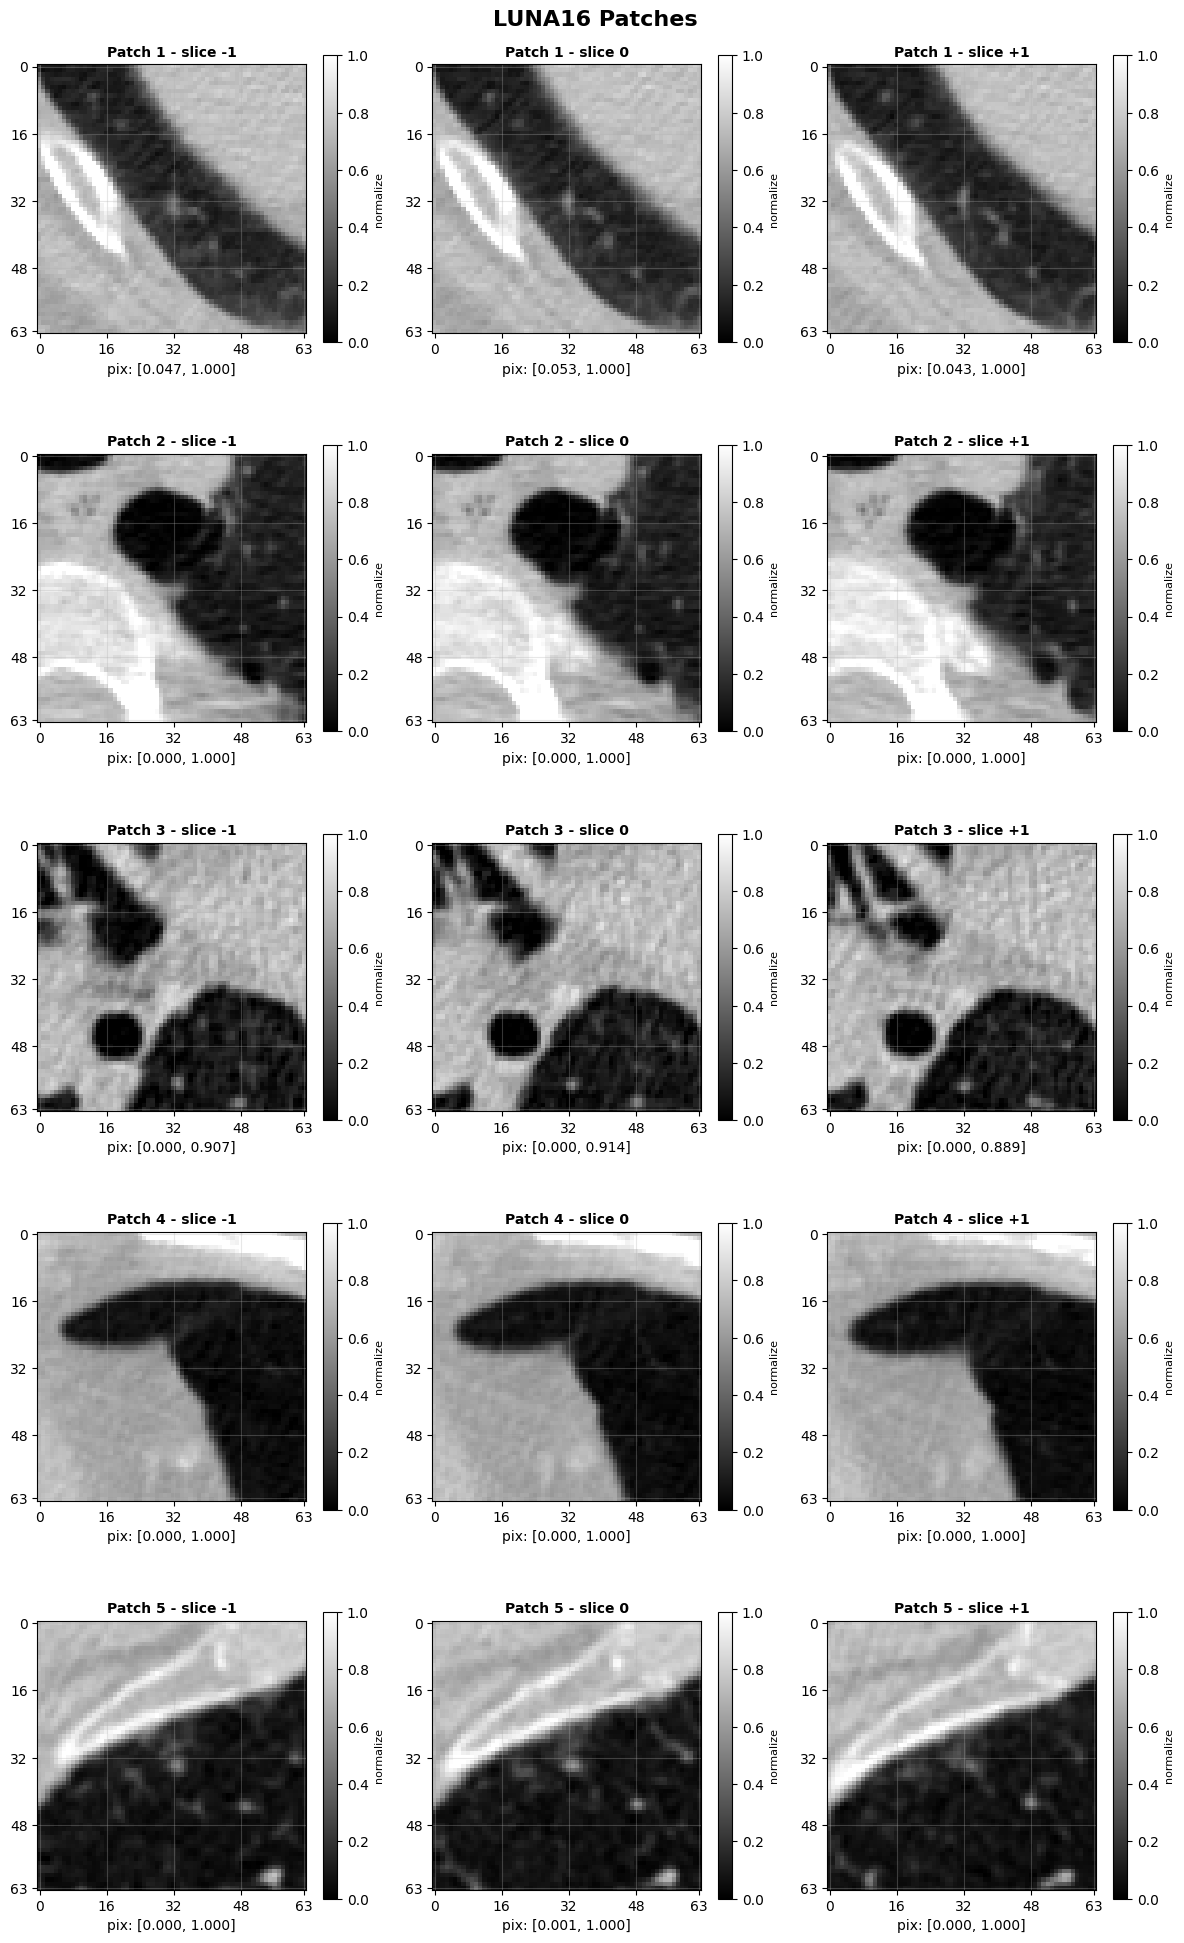


🎉 成功展示 5 个高质量patches!
💡 这些patches都来自切片数>500的清晰CT样本


In [8]:
# 🔍 随机展示5个高质量patches - 每个显示3个切片层
import random
import matplotlib.pyplot as plt

def visualize_random_patches(output_dir: str, num_patches: int = 5):
    """随机选择patches并可视化每个patch的3个切片"""
    
    output_path = Path(output_dir)
    patch_files = list(output_path.glob("*.npz"))
    
    if len(patch_files) == 0:
        print("❌ 未找到任何patch文件")
        return
    
    print(f"📁 找到 {len(patch_files)} 个patch文件")
    
    # 随机选择patches
    selected_files = random.sample(patch_files, min(num_patches, len(patch_files)))
    
    # 创建大图
    fig, axes = plt.subplots(num_patches, 3, figsize=(12, 4*num_patches))
    if num_patches == 1:
        axes = axes.reshape(1, -1)
    
    plt.suptitle('LUNA16 Patches', 
                 fontsize=16, fontweight='bold')
    
    for i, patch_file in enumerate(selected_files):
        try:
            # 加载patch数据
            data = np.load(patch_file)
            patch = data['data']  # shape: (3, 64, 64)
            data.close()
            
            print(f"🔍 Patch {i+1}: {patch_file.name}")
            print(f"   形状: {patch.shape}, 类型: {patch.dtype}")
            print(f"   数值范围: [{patch.min():.3f}, {patch.max():.3f}]")
            
            # 显示3个切片层
            slice_names = ['slice -1', 'slice 0', 'slice +1']
            
            for j in range(3):
                ax = axes[i, j]
                
                # 显示切片
                im = ax.imshow(patch[j], cmap='gray', vmin=0, vmax=1)
                
                # 设置标题和标签
                ax.set_title(f'Patch {i+1} - {slice_names[j]}', 
                           fontsize=10, fontweight='bold')
                ax.set_xlabel(f'pix: [{patch[j].min():.3f}, {patch[j].max():.3f}]')
                
                # 添加网格和坐标
                ax.grid(True, alpha=0.3)
                ax.set_xticks([0, 16, 32, 48, 63])
                ax.set_yticks([0, 16, 32, 48, 63])
                
                # 添加颜色条
                cbar = plt.colorbar(im, ax=ax, shrink=0.8)
                cbar.set_label('normalize', fontsize=8)
            
            print(f"   ✅ 已展示3个切片层")
            
        except Exception as e:
            print(f"   ❌ 加载失败: {e}")
            continue
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎉 成功展示 {len(selected_files)} 个高质量patches!")
    print("💡 这些patches都来自切片数>500的清晰CT样本")

# 执行可视化
if 'quiet_processor' in locals():
    print("🎨 开始可视化随机patches...")
    visualize_random_patches(quiet_processor.output_dir, num_patches=5)
else:
    print("❌ 请先运行处理器生成patches")